# Floresta Aleatória

## Resumo dos resultados dessa etapa

Foi ajustado um modelo do tipo Floresta Aleatória aos dados.

Após exploração aleatória dos hiperparâmetros, a acurácia média atingida pelo modelo foi de 75%.

## Breve explicação e referências sobre o método

## Detalhamento da etapa

### Imports

In [1]:
import requests
from io import BytesIO
import joblib
import numpy as np

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

from random import seed, choice

import lime
import lime.lime_tabular

import eli5
import shap
shap.initjs()

In [2]:
def load_remote_joblib(url):
    """função utilizada para carregar joblib de fonte remota
    ESSA FUNCAO É PERIGOSA
    a função joblib.load pode executar código arbitrário durante sua execuççao
    não utilize essa parte do código se você não tiver certeza do que está fazendo
    """
    content = requests.get(url).content
    return joblib.load(BytesIO(content))
    

x_scaler = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/x_scaler.joblib")
scaled_X = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/scaled_X.joblib")

y_scaler = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/y_scaler.joblib")
scaled_y = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/scaled_y.joblib")

feature_names = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/features.joblib")
categories = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/categories.joblib")

### Tunning

O número de parâmetros para tunar aqui é bem maior do que os anteriores

Usando RandomSearchCV para busca de hiperparâmetros

In [3]:
max_depth = [int(x) for x in np.arange(1, 11)]
max_features = ['auto', 'sqrt']
min_samples_leaf = [int(2**x) for x in np.arange(0, 4)]
min_samples_slit = [int(2**x) for x in np.arange(4, 8)]
n_estimators = [int(x) * 100 for x in np.arange(1, 8)]

param_grid ={
    'max_depth':max_depth,
    'max_features':max_features,
    'min_samples_leaf':min_samples_leaf,
    'min_samples_split':min_samples_slit,
    'n_estimators':n_estimators,
}

In [4]:
rfr = RandomForestClassifier()

In [5]:
rfr_rs = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=param_grid,
    n_iter=30,
    cv=3,
    random_state=42
)

In [6]:
rfr_rs.fit(scaled_X, scaled_y.ravel())

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [16, 32, 64, 128],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700]},
                   random_state=42)

## Modelo

In [7]:
rf_model = rfr_rs.best_estimator_

In [8]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 16,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Performance

In [9]:
print(classification_report(
    scaled_y,
    rf_model.predict(scaled_X),
    target_names=categories
))

              precision    recall  f1-score   support

   gini_alto       0.77      0.72      0.74      2779
  gini_baixo       0.74      0.78      0.76      2781

    accuracy                           0.75      5560
   macro avg       0.75      0.75      0.75      5560
weighted avg       0.75      0.75      0.75      5560



In [10]:
joblib.dump(rf_model, 'data_gini/rf_model.joblib')

['data_gini/rf_model.joblib']

## Interpretabilidade

Sorteio de uma observação para ser utilizada nos algorítimos de interpretabilidade

In [11]:
seed(42)

random_obs_idx = choice(range(len(scaled_X)))

In [12]:
random_obs = scaled_X[random_obs_idx]

### ELI5

In [13]:
eli5.show_weights(rf_model, feature_names=feature_names)

Weight,Feature
0.1653 ± 0.3796,Assistência Técnica (%)
0.1644 ± 0.3086,Estabelecimento Agropecuário (N)
0.0968 ± 0.2575,Rendimento-Milho (kg/ha)
0.0807 ± 0.2388,Carga de Bovinos (n/ha)
0.0695 ± 0.1926,Área lavoura/ Trator(ha)
0.0560 ± 0.1708,Bovinos-Leite(%)
0.0481 ± 0.1522,Rendimento-Cana (kg/ha)
0.0350 ± 0.1238,Área lavoura/ Adubadeira (ha)
0.0236 ± 0.0823,Atividade-Lavoura Temporária (%)
0.0203 ± 0.0846,Uso das terras-Lavoura(%)


In [15]:
eli5.explain_prediction_sklearn(rf_model, random_obs,feature_names=feature_names)

Explanation(estimator="RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_split=16,\n                       n_estimators=400)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.4999482913669065, std=None, value=1.0), FeatureWeight(feature='Estabelecimento Agropecuário (N)', weight=0.06443576427094098, std=None, value=0.212739545348747), FeatureWeight(feature='Assistência Técnica (%)', weight=0.05409926168561099, std=None, value=0.0977389), FeatureWeight(feature='Rendimento-Milho (kg/ha)', weight=0.03137653795894927, std=None, value=0.09081464968152865), FeatureWeight(feature='Área lavoura/ Trator(ha)', weight=0.028019929440165035, std=None, value=0.0547546573780609), FeatureWeight(feature='Atividade-Pesca(%)', weight=0.022781969552084634, std=None, value=0.3131479604188101), FeatureWeight(feature='Carga de Bovinos (n/ha)', weight=0.019875115696696925, std=None, value=0.0011430760026614629), FeatureWeight(feature='Atividade-Lavoura Temporária (%)', weight=0.016774004263934574, std=None, value=0.45258899999999996), FeatureWeight(feature='Área lavoura/ Adubadeira (ha)', weight=0.014409171316890608, std=None, value=0.07784887220707483), FeatureWeight(feature='Rendimento-Cana (kg/ha)', weight=0.014152178873182016, std=None, value=0.014194350000000001), FeatureWeight(feature='Agricultura familiar (%)', weight=0.011820839299026728, std=None, value=0.884756), FeatureWeight(feature='Aves-Corte (%)', weight=0.007392288921657284, std=None, value=0.18482158664400541), FeatureWeight(feature='Pessoal Ocupado / Estabelecimento (Pessoa)', weight=0.007059717858126129, std=None, value=0.01993800254985801), FeatureWeight(feature='Rendimento-Arroz (kg/ha)', weight=0.005106139175598283, std=None, value=0.14166666666666666), FeatureWeight(feature='Atividade-Pecuária(%)', weight=0.005042988164948564, std=None, value=0.296499), FeatureWeight(feature='Uso das terras-Lavoura(%)', weight=0.004514360054006581, std=None, value=0.05240028614352984), FeatureWeight(feature='Atividade-Aquicultura(%)', weight=0.003999202030817016, std=None, value=0.0007293950000000001), FeatureWeight(feature='Área lavoura/ Semeadeira(ha)', weight=0.0033756794877643193, std=None, value=0.08698540437670874), FeatureWeight(feature='Utilização de Agrotóxicos (%)', weight=0.0032057257991051024, std=None, value=0.19671500000000003), FeatureWeight(feature='Área lavoura/ Colheitadeira(ha)', weight=0.0029297337623305593, std=None, value=0.0), FeatureWeight(feature='Rendimento-Soja (kg/ha)', weight=0.0028436947905229747, std=None, value=0.0), FeatureWeight(feature='Produtor com escolaridade até Ensino Fundamental(%)', weight=0.002210615552909342, std=None, value=0.63895), FeatureWeight(feature='Rendimento-Uva(kg/ha)', weight=0.0021566457586394755, st

### LIME

In [16]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=scaled_X,
    feature_names=feature_names,
    class_names=categories,
    mode='classification'
)

lime_exp_rl = explainer.explain_instance(
    random_obs,
    rf_model.predict_proba,
)

In [17]:
lime_exp_rl.show_in_notebook()

### SHAP

In [18]:
shap_rl_expainer = shap.KernelExplainer(
    rf_model.predict_proba,
    shap.sample(scaled_X, random_state=42)
)

In [19]:
shap_rl_values = shap_rl_expainer.shap_values(shap.sample(scaled_X, random_state=42))

  0%|          | 0/100 [00:00<?, ?it/s]

O código abaixo gera um gráfico bastante interessante, porém pesado, e foi omitido para melhorar a navegação nesse anexo.

```python
shap.force_plot(
    shap_rl_expainer.expected_value[0],
    shap_rl_values[0],
    feature_names=feature_names
)
```

Com pequenas modificações, o mesmo método também pode ser utilizado para os outros modelos.

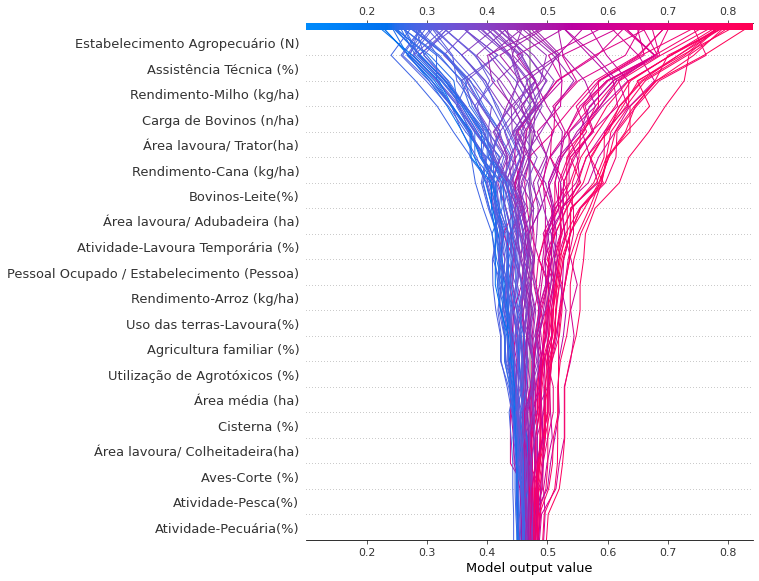

In [21]:
shap.decision_plot(
    shap_rl_expainer.expected_value[0],
    shap_rl_values[0],
    feature_names=feature_names
)

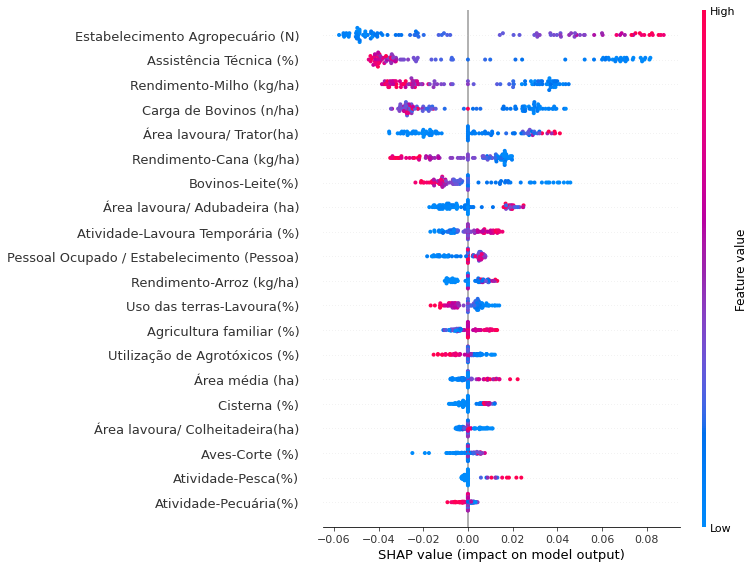

In [22]:
shap.summary_plot(
    shap_rl_values[0],
    features=shap.sample(scaled_X, random_state=42),
    feature_names=feature_names
)